In [1]:
from __future__ import print_function, division
from builtins import range

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

import warnings
warnings.filterwarnings("ignore")


C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

In [2]:
class FeatureTransformer:
    
    
    def __init__(self, env, n_components=500):
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)


        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
                ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

In [3]:
class Model:
    
    def __init__(self, env, feature_transformer, learning_rate):
        
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate=learning_rate)
            model.partial_fit(feature_transformer.transform( [env.reset()] ), [0])
            self.models.append(model)
    
    def predict(self, s):
        X = self.feature_transformer.transform([s])
        result = np.stack([m.predict(X) for m in self.models]).T
        assert(len(result.shape) == 2)
        return result
    
    def update(self, s, a, G):
        X = self.feature_transformer.transform([s])
        assert(len(X.shape) == 2)
        self.models[a].partial_fit(X, [G])

    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))
        
        

def run_episode(model, env, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    num_traj = 0
    
    while not done and num_traj < 10000:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        next = model.predict(observation)
        G = reward + gamma*np.max(next[0])
        model.update(prev_observation, action, G)
        totalreward += reward
        num_traj += 1
        
    return totalreward

Iteration: 10 total reward: -200.0
Iteration: 20 total reward: -200.0
Iteration: 30 total reward: -168.0
Iteration: 40 total reward: -182.0
Iteration: 50 total reward: -200.0
Iteration: 60 total reward: -151.0
Iteration: 70 total reward: -148.0
Iteration: 80 total reward: -146.0
Iteration: 90 total reward: -162.0
Iteration: 100 total reward: -155.0
Iteration: 110 total reward: -181.0
Iteration: 120 total reward: -115.0
Iteration: 130 total reward: -114.0
Iteration: 140 total reward: -149.0
Iteration: 150 total reward: -104.0
Iteration: 160 total reward: -111.0
Iteration: 170 total reward: -109.0
Iteration: 180 total reward: -105.0
Iteration: 190 total reward: -108.0
Iteration: 200 total reward: -109.0
Iteration: 210 total reward: -115.0
Iteration: 220 total reward: -111.0
Iteration: 230 total reward: -110.0
Iteration: 240 total reward: -112.0
Iteration: 250 total reward: -107.0
Iteration: 260 total reward: -107.0
Iteration: 270 total reward: -87.0
Iteration: 280 total reward: -104.0
It

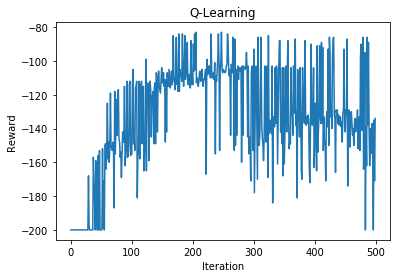

In [4]:
def main(show_plots=True):
    
    env = gym.make('MountainCar-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft, "constant")
    gamma = 0.99



    N = 500 # iteration 500
    totalrewards = np.empty(N)
    for n in range(N):
        eps = 0.1*(0.97**n) ## episode 갈수록 줄어듬

        totalreward = run_episode(model, env, eps, gamma)
        totalrewards[n] = totalreward
        if (n + 1) % 10 == 0:
            print("Iteration:", n+1, "total reward:", totalreward)
            
    if show_plots:
        
        plt.plot(totalrewards)
        plt.xlabel('Iteration')
        plt.ylabel('Reward')
        plt.title("Q-Learning")
        plt.show()
    

if __name__ == '__main__':

    main()